# Introduction

In this Project, we will demonstrate how to use deep reinforcement learning to recommend good pairs of t-shirts and jeans to customers.  

### Problem

**Recommend users colored t-shirt and jeans that match their taste**


### Key Assumption

Here we will base our assumption based on the following:   
- Users will be recommended colors of t-shirts and jeans, sequentially.
- If the color does not match the user's taste, the the user will ask for another recommendation.
- The recommendation system will recommend another color until the color matches the user's taste.

### Detailed Assumption

Here we will define the problem base on the following assumption:
- The recommendation system will propose multiple colors of t-shirts, and then jeans.
- After both are finished, episode terminates.
- User's will not quite when asking for recommendation.
- User's can be grouped into A and B, and each group has a taste distrubtion.
- User's are defined based on 3 features.
- User's will likely choose the color of their jeans that matches their t-shirt.
- 6 colors will exist for t-shirts and jeans, respectively.
- If the color matches the user's taste, we give a reward of +1, else -1.   
    ex)    
    If t-shirt and jeans were successfully recommended without making any mistakes, +2 reward is given.   
    If both used all actions to guess user's taste, then total reward of -10 in episode is given.

- If the color matches the user's taste, then it will change its target clothes.   
    ex)   
    If t-shirt recommendation succeeds, the recommendation system will recommend jeans.   
    If jeans succeed, it will terminate the episode

**Note**
This notebook is based on groups choosing colors **stochastically/deterministically**.   
Users will have different taste within a group but will deterministically choose the same color shirt.


http://www.lamda.nju.edu.cn/yuy/GetFile.aspx?File=papers/kdd18-RobustDQN.pdf&AspxAutoDetectCookieSupport=1

In [1]:
import random
import numpy as np
random.seed(123)
np.random.seed(123)

In [2]:
sample_data=1000

# 1. Generating Data

## People Data

Here, we will generate user's unique data with 3 features.   
We will generate x1 as Group A's data and x2 as Group B's data.

In [3]:
x1=np.random.normal(-1,0.1,(sample_data//2,3))
x2=np.random.normal(1,0.1,(sample_data//2,3))

## T-shirt and Jeans Consuming Probability

In this section, we will generate purchase probability for groups A and B.   
Here, we will assume users can choose 6 different colored t-shirt and jeans.

In [4]:
p1=np.array([0.9,0.02,0.02,0.02,0.02,0.02])
p2=np.array([0.02,0.9,0.02,0.02,0.02,0.02])


def shirt(idx):
    pr=p1 if idx==0 else p2
    pr = pr/pr.sum()
    return np.random.choice(len(p1),p=pr)

# if customer buys certain colored shirt, the customer will have a high probability of buying the same colored jeans
def jeans(idx):
    p_=np.zeros((len(p1),))
    p_[idx]=1
    pr=np.where(p_==1,0.8,0.0)
    pr = pr/pr.sum()
    return np.random.choice(len(p1),p=pr)

# generates data
def out_data_prob(idx,size):
    res = np.zeros((size,2))
    for i in range(size):
        r=shirt(idx)
        j=jeans(r)
        res[i,0]=r
        res[i,1]=j
    return res
    

z1=out_data_prob(0,sample_data//2)
z2=out_data_prob(1,sample_data//2)

## Merging 2 

In [5]:
r1=np.concatenate((x1,z1),axis=1)
r2=np.concatenate((x2,z2),axis=1)

dataset=np.concatenate([r1,r2],axis=0)

# 2. Modifying Filter of RenomRL

In [6]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a

    return y 


In [7]:
from renom_rl.utility.filter import DiscreteNodeChooser
from renom_rl.utility.fixer import transform_node_2_numpy

class MaskMaxNodeChooser(DiscreteNodeChooser):

    
    def __call__(self,x,y):
        return self.forward(x,y)
    
    def forward(self, node_var, mask):

        node_var = transform_node_2_numpy(node_var)
        
        res = softmax(node_var - np.where(mask[None,...],0,100000))

        max_list = np.argmax(res, axis=1).reshape((-1, 1))
        
        if len(max_list) == 1:
            return int(max_list)
        else:
            return max_list

# 3. Import and Modify ReNomRL's DQN

Here we will use ReNom RL and modify it.   
For this recommendation system, we will use DQN.   
To simplify what DQN is, DQN is an algorithm that chooses action based on expected future reward.   
It explores action using epsilon greedy algorithm.   
Exploitation and exploration rate shifts based on how much steps the agent takes.   
For this example, we gradually shift the action decision from exploration to exploitation by steps.   
For further understanding, go to renom.jp.   

In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import copy
import numpy as np
from warnings import warn
from numbers import Number
import inspect
import renom as rm

from renom_rl.utility.replaybuffer import ReplayBuffer
from renom_rl import AgentBase
from renom_rl.environ.env import BaseEnv
from renom_rl.utility.gradients import GradientClipping
from renom_rl.utility.filter import EpsilonGreedyFilter, EpsilonSLFilter, EpsilonCFilter, DiscreteNodeChooser, ProbNodeChooser, MaxNodeChooser
from renom_rl.utility.logger import Logger, DQNLogger, AVAILABLE_KEYS
from renom_rl.utility.fixer import fix_envs_testenvs, fix_single_env, fix_optimizer,\
    fix_action_range, check_shape, check_reset_method, check_output_state, \
    check_step_method, fix_logger, fix_tuple_shape, fix_instance, fix_loss_function, fix_instance2, \
    ArgumentCheck, decorator, test_decorator
from renom_rl.utility.additional_modules import deepcopy

_dqn_keys = AVAILABLE_KEYS["dqn"]["logger"]
_dqn_keys_epoch = AVAILABLE_KEYS["dqn"]["logger_epoch"]


class DQN(AgentBase):

    def __init__(self, env, q_network, logger=None,
                 batch_size=32, update_period=10000, train_frequency=4,
                 optimizer=None, gamma=0.99, buffer=None,
                 node_selector=None, test_node_selector=None,
                 action_filter=None, test_action_filter=None,
                 gradient_clipping=None, loss_func=None, initialize=True):

        super(DQN, self).__init__()
        local_init = locals()
        self._arg_check = ArgumentCheck(list(local_init.keys()), remove=[
                                        "__class__", "self", "env", "q_network", "logger"])

        kwargs_set = lambda **kwargs: kwargs
        self._arg_base = kwargs_set(batch_size=[None, int, fix_instance2, {"positive": True, "non_neg": True}],
                                    update_period=[None, int, fix_instance2,
                                                   {"positive": True, "non_neg": True}],
                                    train_frequency=[None, int, fix_instance2,
                                                     {"positive": True, "non_neg": True}],
                                    optimizer=[rm.Rmsprop(lr=0.00025, g=0.95),
                                               rm.Optimizer, fix_instance],
                                    gamma=[None, float, fix_instance2, {
                                        "positive": True, "range": [0., 1.]}],
                                    buffer=[ReplayBuffer(), ReplayBuffer, fix_instance],
                                    node_selector=[
                                        MaskMaxNodeChooser(), DiscreteNodeChooser, fix_instance],
                                    test_node_selector=[
                                        MaskMaxNodeChooser(), DiscreteNodeChooser, fix_instance],
                                    action_filter=[EpsilonSLFilter(epsilon_step=int(
                                        0.8 * 50000)), EpsilonGreedyFilter, fix_instance],
                                    test_action_filter=[
                                        EpsilonCFilter(), EpsilonGreedyFilter, fix_instance],
                                    gradient_clipping=[None, GradientClipping, fix_instance],
                                    loss_func=[rm.ClippedMeanSquaredError(), None, fix_instance],
                                    initialize=[None, bool, fix_instance2],
                                    )
        # Set Models.
        self._q_network = fix_instance(q_network, None, rm.Model, "q_network")
        self._target_q_network = deepcopy(self._q_network)
        self._best_q_network = deepcopy(self._q_network)
        # logger
        self._logger = fix_logger(logger, _dqn_keys, _dqn_keys_epoch, DQNLogger())
        # Check Env class type.
        envs, test_env = fix_envs_testenvs(env)
        self._env, self._test_env, state_shape, action_shape = fix_single_env(envs, test_env)


        # Set common params
        res = self._fixer(local_init)
        for k, v in res.items():
            self._arg_base[k][0] = v
            self._arg_base[k][2] = fix_instance
            self.__dict__["_%s" % k] = v
        self._loss_func = fix_loss_function(loss_func, rm.ClippedMeanSquaredError())
        _ = self._buffer([1, ], state_shape)

        # Reset Model
        if initialize:
            self._initializer()

        # action_filter_during_fit
        self._action_filter_during_fit = self._action_filter

        # private info
        self._private_info = {**local_init, **{k: v[0] for k, v in self._arg_base.items()}}
        self._private_info_test = self._push_test_info()

    def _initializer(self):
        '''Target q-network is initialized with same neural network weights of q-network.'''
        # Reset weight.
#         for layer in self._q_network.iter_models():
#             if hasattr(layer, "params"):
#                 layer.params = {}

#         for layer in list(self._target_q_network.iter_models()):
#             if hasattr(layer, "params"):
#                 layer.params = {}


    def _action(self, state, node_selector, env):
        """This method returns an action according to the given state.
        """
        self._q_network.set_models(inference=True)
        act = self._q_network(np.array([state for _ in range(*env.action_shape)]), np.array(np.arange(*env.action_shape)).reshape(-1,1))
        act = act.reshape(1,-1)
        return node_selector(act,env.mask())

    def _rec_copy(self, obj1, obj2):
        """This function copies the batch normalization parameters"""
        for item_keys in obj1.__dict__.keys():
            if isinstance(obj1.__dict__[item_keys], rm.BatchNormalize):
                obj1.__dict__[item_keys]._mov_mean = obj2.__dict__[item_keys]._mov_mean
                obj1.__dict__[item_keys]._mov_std = obj2.__dict__[item_keys]._mov_std
            elif isinstance(obj1.__dict__[item_keys], rm.Model):
                self._rec_copy(obj1.__dict__[item_keys], obj2.__dict__[item_keys])

    def _update(self):
        """This function updates target network."""
        # A(B) Copy B to A.
        self._target_q_network.copy_params(self._best_q_network)
        self._rec_copy(self._target_q_network, self._best_q_network)

    def _update_best_q_network(self):
        """This function updates best network in each target update period."""
        self._best_q_network.copy_params(self._q_network)
        self._rec_copy(self._best_q_network, self._q_network)

    @decorator(["epoch", "epoch_step", "random_step", "test_step"])
    def fit(self, epoch=1, epoch_step=250000, random_step=50000,
            batch_size=None, test_step=None,
            update_period=None, train_frequency=None,
            optimizer=None, gamma=None, buffer=None,
            node_selector=None, test_node_selector=None,
            action_filter=None, test_action_filter=None,
            gradient_clipping=None, loss_func=None, initialize=None):

        # acquiring arguments as local variables
        epoch = fix_instance2(epoch, int, "epoch", positive=True, non_neg=True)
        epoch_step = fix_instance2(epoch_step, int, "epoch_step", positive=True, non_neg=True)
        random_step = fix_instance2(random_step, int, "random_step", positive=True)
        test_step = fix_instance(test_step, None, None, "test_step", positive=True, non_neg=True)

        _q_network = self._q_network
        target_q_network = self._target_q_network
        best_q_network = self._best_q_network
        env = self._env
        test_env = self._test_env
        logger = self._logger
        self._action_filter_during_fit = action_filter

        buffer([1, ], test_env.state_shape)
        buffer.set_network(_q_network,target_q_network,gamma)
        
        buffer2 = ReplayBuffer()
        buffer2([1, ], test_env.state_shape)
        buffer.set_network(_q_network,target_q_network,gamma)
        
        loss_func = fix_loss_function(loss_func, rm.ClippedMeanSquaredError())
        # Reset Model
        if initialize:
            self._initializer()

        # random step phase
        print("Run random {} step for storing experiences".format(random_step))

        state = env.reset()

        # env start(after reset)
        env.start()

        for i in range(1, random_step + 1):
            action = env.sample()
            next_state, reward, terminal = env.step(action)
            
#             if state[0] > 0:
            if env.mode > 0:
                buffer.store(state, np.array(action),
                             np.array(reward), next_state, np.array(terminal))
            else:
                buffer2.store(state, np.array(action),
                             np.array(reward), next_state, np.array(terminal))
            state = next_state
            if terminal:
                state = env.reset()

        # History of Learning
        max_reward_in_each_update_period = -np.Inf

        count = 0  # update period
        step_count = 0  # steps
        episode_count = 0  # episodes

        # 1 epoch stores multiple epoch steps thus 1 epoch can hold multiple episodes
        for e in range(1, epoch + 1):
            continuous_step = 0
            continuous_step_log = 0
            sum_reward = 0
            sum_reward_log = 0
            nth_episode = 0

            logger.start(epoch_step)

            # env epoch
            env.epoch()

            state = env.reset()
            loss = 0

            for j in range(epoch_step):
                # for stop epoch after 1 step
                if j and env.stop_epoch():
                    continue

                # set action
                act = self._action(state, node_selector, env)
                action = action_filter(act, env.sample(),
                                       step=step_count, episode=episode_count, epoch=e)
                greedy = action_filter.value()

                # pass it to env
                next_state, reward, terminal = env.step(action)

#                 if state[0] > 0:
                if env.mode > 0:
                    buffer.store(state, np.array(action),
                             np.array(reward), next_state, np.array(terminal))
                else:
                    buffer2.store(state, np.array(action),
                                 np.array(reward), next_state, np.array(terminal))

               # env epoch step
                env.epoch_step()

                sum_reward += reward

                if j % train_frequency == 0 and j:
#                     if len(buffer) > batch_size:
                    if len(buffer) > batch_size//2 and len(buffer2) > batch_size//2:
                        train_prestate1, train_action1, train_reward1, train_state1, train_terminal1 = \
                            buffer.get_minibatch(batch_size//2)
                        
                        train_prestate2, train_action2, train_reward2, train_state2, train_terminal2 = \
                            buffer2.get_minibatch(batch_size//2)
                        
                        train_prestate = np.concatenate((train_prestate1,train_prestate2))
                        train_action = np.concatenate((train_action1,train_action2))
                        train_reward = np.concatenate((train_reward1,train_reward2))
                        train_state = np.concatenate((train_state1,train_state2))
                        train_terminal = np.concatenate((train_terminal1,train_terminal2))

#                         train_prestate = train_prestate1
#                         train_action = train_action1
#                         train_reward = train_reward1
#                         train_state = train_state1
#                         train_terminal = train_terminal1
                        
                        

                        # getting q values as target reference
                        _q_network.set_models(inference=True)
                        target_q_network.set_models(inference=True)

                        target = self._q_network(train_prestate, train_action).as_ndarray()

                        target.setflags(write=True)
                        
                        
                        n_action=np.zeros((batch_size,1))
                        for i in range(batch_size):
                            val_i = self._target_q_network(np.array([train_state[i] for _ in range(*env.action_shape)]), np.array(np.arange(*env.action_shape)).reshape(-1,1)).as_ndarray()
                            n_action[i] = np.argmax(val_i.reshape(-1))
                        
                        
                        
                        value = self._target_q_network(train_state, n_action).as_ndarray()\
                                        * gamma * (~train_terminal[:, None])
                        
#                         max_q_action = np.argmax(_q_network(train_state).as_ndarray(), axis=1)
#                         value = target_q_network(train_state).as_ndarray()[(range(len(train_state)),
#                                                                             max_q_action)][:, None] * gamma * (~train_terminal[:, None])

                        # getting target value
                        for i in range(batch_size):
                            target[i] = train_reward[i] + value[i]

                        # train
                        _q_network.set_models(inference=False)
                        with _q_network.train():
                            z = self._q_network(train_prestate,train_action)
                            ls = loss_func(z, target)
                        grad = ls.grad()

                        if gradient_clipping:
                            gradient_clipping(grad)

                        grad.update(optimizer)
                        loss = np.sum(ls.as_ndarray())
                        buffer.update()
                        # train_loss += loss

                if count % update_period == 0 and count:
                    max_reward_in_each_update_period = -np.Inf
                    self._update()
                    count = 0
                count += 1

                # terminal reset
                if terminal:
                    if max_reward_in_each_update_period <= sum_reward:
                        self._update_best_q_network()
                        max_reward_in_each_update_period = sum_reward

                    # train_sum_rewards_in_each_episode.append(sum_reward)
                    # hold log values
                    sum_reward_log = sum_reward
                    continuous_step_log = continuous_step
                    # reset log values
                    sum_reward = 0
                    continuous_step = 0
                    # increment episode values
                    nth_episode += 1
                    episode_count += 1

                    env.reset()

                logger.update(1)
                logger.logger(state=state, action=action, reward=reward,
                              terminal=terminal, next_state=next_state,
                              total_step=step_count, epoch_step=j, max_step=epoch_step,
                              total_episode=episode_count, epoch_episode=nth_episode, steps_per_episode=continuous_step_log,
                              epoch=e, max_epoch=epoch, loss=loss,
                              sum_reward=sum_reward_log, epsilon=greedy)
                # self.logger.update(1)

                continuous_step += 1
                step_count += 1
                state = next_state

                # if terminate executes, then do execute "continue"
                if env.terminate() or env.terminate_epoch():
                    break

            else:
                summed_test_reward = self.test(test_step, test_action_filter, test_node_selector)
                logger.logger_epoch(total_episode=episode_count, epoch_episode=nth_episode,
                                    epoch=e, max_epoch=epoch, test_reward=summed_test_reward, epsilon=greedy)
                logger.close()
                continue

            logger.close()
            if env.terminate():
                break

        # env close
        env.close()

    @test_decorator
    def test(self, test_step=None, action_filter=None, node_selector=None):
        """
        Test the trained agent.
        Refer to ``DQN`` for other argument descriptions.

        Args:
            test_step (int, None): Number of steps (not episodes) for test. If None is given, this method tests execute only 1 episode.

        Returns:
            Sum of rewards. (float)
        """
        env = self._test_env
        # if filter_obj argument was specified, the change the object
        test_step = fix_instance(test_step, None, int, "test_step", positive=True, non_neg=True)
        # action_filter = fix_instance(action_filter, self._test_action_filter,
        #                              EpsilonGreedyFilter, "action_filter")
        # node_selector = fix_instance(node_selector, self._test_node_selector,
        #                              DiscreteNodeChooser, "node_selector")
        action_filter.check_instance(self._action_filter_during_fit)

        sum_reward = 0
        env.test_start()
        state = env.reset()

        if test_step is None:
            while True:
                action = action_filter.test(self._action(
                    state, node_selector, env), env.sample())

                state, reward, terminal = env.step(action)

                sum_reward += float(reward)

                env.test_epoch_step()

                if terminal or env.test_terminate():
                    break

        else:
            for j in range(test_step):
                action = action_filter.test(self._action(
                    state, node_selector, env), env.sample())

                state, reward, terminal = env.step(action)

                sum_reward += float(reward)

                env.test_epoch_step()

                if terminal:
                    env.reset()

                if env.test_terminate():
                    break

        env.test_close()

        return sum_reward


In [9]:
from renom_rl.environ import BaseEnv
# from renom_rl.discrete.dqn import DQN
import renom as rm
from renom_rl.utility.filter import EpsilonSLFilter

# 4. Defining NN and Env

In [10]:
from renom.utility.initializer import GlorotNormal

class NN(rm.Model):
    def __init__(self):
        self.d1=rm.Dense(32)
        self.d2=rm.Dense(32)
        self.d3=rm.Dense(32)
        self.d4=rm.Dense(1,initializer=GlorotNormal(gain=0.1))
        
        self.emb = rm.Embedding(32,6)
        self.ad1 = rm.Dense(32)
        self.r=rm.Relu()
        
    def forward(self,x,action):
        h=self.d1(x)
#         h=self.r(h)
#         h=self.d2(h)
#         h=self.r(h)
        
        a = self.emb(action)
        a = self.r(a)
        a = self.ad1(a)
        a = self.r(a)
        h = rm.concat(h,a)
        h=self.d3(h)
        h=self.r(h)
        h=self.d4(h)
        return h
model=NN()

In [11]:
class CustomerEnv(BaseEnv):
    def __init__(self, dataset, randomness=True):
        self.action_shape=(len(p1),)
        self.state_shape=(3+len(p1)*2,)
        
        self.idx = 0
        self.l = len(dataset)
        self.randomness = randomness
        self.in_data = dataset[:,0:3]
        self.out_data = dataset[:,3:5]
        self.mode = 0
        self._a_list=[]

        
    def reset(self):
        self._a_list = []
        self.mode = 0
        
        if self.randomness:
            self.idx = np.random.randint(self.l)
        else:
            self.inc()
            
        self.state = np.concatenate((self.in_data[self.idx],np.zeros((len(p1)*2,)))) 
    
        return self.state
        
    def step(self,action):
        target = self.out_data[self.idx,self.mode]

        if action in self._a_list:
            raise Exception("{} already in list".format(action))

        self._a_list.append(action)
        
        if self.mode == 0:
            self.state[3+action]= -0.2#1 - (len(self._a_list)-1)*0.2
        else:
            self.state[3+len(p1)+action]= -0.2#1 - (len(self._a_list)-1)*0.2
            
        if target==action:
            reward = 1 - (len(self._a_list) - 1)*0.2
            
#             self.state = np.concatenate((self.in_data[self.idx],np.zeros((len(p1)*2,))))
            
            if self.mode == 0:
                self.state = np.concatenate((self.in_data[self.idx],np.zeros((len(p1)*2,))))
                self.state[3+action]=1
                self.state2 = self.state
            else:
                self.state = self.state2
                self.state[3+len(p1)+action]=1
                
            self.mode += 1
            self._a_list = []
            terminal = True if self.mode > 1 else False
            
        else:
            reward = -1 #1 - 0.2*(len(self._a_list)-1)
            terminal = False
        
        return self.state, reward, terminal
    
    def avail(self):
        a_list = np.array(self._a_list)
        a_range = np.arange(*self.action_shape)
        a_avail = np.where(np.isin(a_range,a_list),0,1)
        return  a_avail
    
    def sample(self):
        
        a_avail = self.avail()
        tot = a_avail.sum()
        a_prob = a_avail/tot if tot > 0 else a_avail

        return np.random.choice(len(a_prob),p=a_prob)
    
    def index(self,x):
        self.idx=x
        
    def inc(self):
        self.idx += 1
        self.idx %= self.l
    
    def mask(self):
        
        return self.avail()

train_env=CustomerEnv(dataset)
test_env=CustomerEnv(dataset)

# 5. Training

In [12]:
dqn=DQN([train_env,test_env],
        model,
        gamma=0.8,
        optimizer=rm.Adam(lr=0.001),
        update_period=10,
        batch_size=64,
        action_filter=EpsilonSLFilter(epsilon_step=15000))

In [13]:
dqn.fit(epoch=1,epoch_step=17000,random_step=0)

epoch 0001 epsilon 0.9979 loss 0.0000 rewards in epoch -9.600 episode 0006 rewards in episode -0.400.:   0%|          | 32/17000 [00:00<02:04, 136.51it/s] 

Run random 0 step for storing experiences


epoch 001 avg_loss:0.1498 total reward in epoch: [train:-682.400 test: 2.0] avg train reward in episode:-0.152 epsilon :0.000: 100%|██████████| 17000/17000 [04:54<00:00, 57.66it/s]


# 6. Result

Here we show the reward for each epsiode.

### Reward Graph

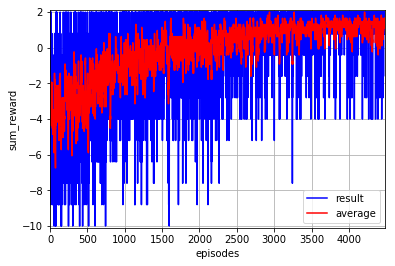

In [14]:
dqn._logger.graph("sum_reward",average_range=[3,3])

### Histogram

(array([1.000e+00, 9.000e+00, 1.100e+01, 7.000e+00, 3.400e+01, 9.500e+01,
        3.410e+02, 0.000e+00, 4.480e+02, 2.535e+03]),
 array([-10. ,  -8.8,  -7.6,  -6.4,  -5.2,  -4. ,  -2.8,  -1.6,  -0.4,
          0.8,   2. ]),
 <a list of 10 Patch objects>)

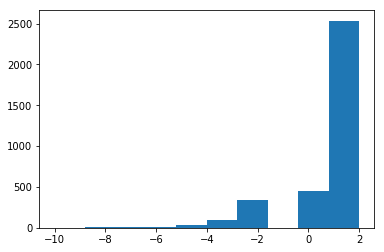

In [15]:
import matplotlib.pyplot as plt

plt.hist(dqn._logger.result()["sum_reward"][1000:])

# 7. Discussion

From the reward graph, we can observe the agent is making multiple mistakes in the beginning, but as it experience more steps, the agent gradually generates better reward value per episode.    
The histogram of the reward represents the frequency of the total reward. From the reward graph, it might be seen as an oscilating graph, but from the histogram, we can observe that the agent is scoring +2 reward frequently, thus we can tell the agent is scoring good during training.

In [16]:
a1=softmax(model(np.array([[-1,-1,-1]+[0,0,0,0,0,0]+[0,0,0,0,0,0] for _ in range(6)]),np.arange(6)[...,None]).reshape(-1))
a2=softmax(model(np.array([[1,1,1]+[0,0,0,0,0,0]+[0,0,0,0,0,0] for _ in range(6)]),np.arange(6)[...,None]).reshape(-1))

In [17]:
print(a1)
print(a2)
print(0,np.argmax(a1))
print(1,np.argmax(a2))

[0.3053004  0.1491112  0.1389946  0.14735186 0.13700391 0.12223797]
[0.13874242 0.24585988 0.14300686 0.17583103 0.14999518 0.14656456]
0 0
1 1


In [18]:

def result(x):
    return np.argmax(softmax(model(np.array([x for _ in range(6)]),np.arange(6)[...,None]).reshape(-1)))

# a1=softmax(model(np.array([-3,-3,-3]+[0,0,0,0,1,0]+[0,0,0,0,0,0])[None,...]))
# a2=softmax(model(np.array([3,3,3]+[0,0,0,0,1,0]+[0,0,0,0,0,0])[None,...]))


for i in range(6):
    
    z1 = [0 for _ in range(6)] 
    z2 = [0 for _ in range(6)] 
    z1[i] = 1
    
#     a1 = [-1,-1,-1] + z1 + z2
#     a2 = [1,1,1] + z1 + z2
    a1 = np.concatenate((x1[0],z1,z2))
    a2 = np.concatenate((x2[0],z1,z2))
    print("for {}".format(i),result(a1),result(a2),"a1:",model(np.array([a1 for _ in range(6)]),np.arange(6)[...,None]).reshape(-1))


for 0 0 0 a1: [-0.724519  -1.5464472 -1.3503065 -1.4770129 -1.6067648 -1.6603442]
for 1 1 1 a1: [-1.7577423 -1.5436747 -2.1366546 -2.0434039 -1.8666538 -2.146932 ]
for 2 2 2 a1: [-1.9188778 -1.841647  -1.2800441 -1.7886022 -1.7765087 -1.9192289]
for 3 3 3 a1: [-1.8674328 -1.9518756 -1.7722968 -1.4154402 -1.8683001 -1.9640875]
for 4 4 4 a1: [-0.9447209 -1.2641925 -1.5285832 -1.5645534 -0.6910663 -1.4532856]
for 5 5 5 a1: [-2.5598881 -2.5737596 -2.2481258 -2.3358514 -2.3850286 -2.246285 ]


In [19]:
x1[0]

array([-1.10856306, -0.90026546, -0.97170215])

In [20]:
x2[0]

array([1.15575737, 1.16424983, 0.94729081])

In [21]:
model.save("model.h5")